In [1]:
# 0. Link colab với Drive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive

Mounted at /content/drive
/content/drive/MyDrive


In [2]:
#####  LOADING AND EXTRACTING DATA   #####


import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle


def data_loader():
    
    # Load dataset file
    data_frame = pd.read_csv('/content/drive/MyDrive/Project AI /training.csv')
    
    data_frame['Image'] = data_frame['Image'].apply(lambda i: np.fromstring(i, sep=' '))
    data_frame = data_frame.dropna()  # Get only the data with 15 keypoints
   
    # Extract Images pixel values
    imgs_array = np.vstack(data_frame['Image'].values)/ 255.0
    imgs_array = imgs_array.astype(np.float32)    # Normalize, target values to (0, 1)
    imgs_array = imgs_array.reshape(-1, 96, 96, 1)
        
    # Extract labels (key point cords)
    labels_array = data_frame[data_frame.columns[:-1]].values
    labels_array = (labels_array - 48) / 48    # Normalize, traget cordinates to (-1, 1)
    labels_array = labels_array.astype(np.float32) 
    
    # shuffle the train data
#     imgs_array, labels_array = shuffle(imgs_array, labels_array, random_state=9)  
    
    return imgs_array, labels_array

  


# # This snippet is just to check/verify data
# imgs, labels = data_loader()
# print(imgs.shape)
# print(labels.shape)

# n=0
# labels[n] = (labels[n]*48)+48
# image = np.squeeze(imgs[n])
# plt.imshow(image, cmap='gray')
# plt.plot(labels[n][::2], labels[n][1::2], 'ro')
# plt.show()
    

In [3]:
######   BUILD, TRAIN AND SAVE THE CONVOLUTIONAL MODEL    ########


from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, Activation
from keras.layers import Flatten, Dense
from tensorflow.keras.layers import BatchNormalization
from keras import optimizers
from keras.callbacks import ModelCheckpoint, History
# from keras.optimizers import Adam


# Main model
def the_model():
    model = Sequential()
    
    model.add(Conv2D(16, (3,3), padding='same', activation='relu', input_shape=X_train.shape[1:])) # Input shape: (96, 96, 1)
    model.add(MaxPooling2D(pool_size=2))
    
    model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    
    # Convert all values to 1D array
    model.add(Flatten())
    
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(30))
    
    return model


X_train, y_train = data_loader()
print("Training datapoint shape: X_train.shape:{}".format(X_train.shape))
print("Training labels shape: y_train.shape:{}".format(y_train.shape))


epochs = 60
batch_size = 64

model = the_model()
hist = History()

checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/Project AI /Output/checkpoint1.hdf5', 
                               verbose=1, save_best_only=True)

# Complie Model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

model_fit = model.fit(X_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, callbacks=[checkpointer, hist], verbose=1)

model.save('/content/drive/MyDrive/Project AI /Output/model1.h5')


Training datapoint shape: X_train.shape:(2140, 96, 96, 1)
Training labels shape: y_train.shape:(2140, 30)
Epoch 1/60
27/27 [==============================] - ETA: 0s - loss: 0.0260 - accuracy: 0.4907
Epoch 1: val_loss improved from inf to 0.01003, saving model to /content/drive/MyDrive/Project AI /Output/checkpoint1.hdf5
27/27 [==============================] - 13s 43ms/step - loss: 0.0260 - accuracy: 0.4907 - val_loss: 0.0100 - val_accuracy: 0.4322
Epoch 2/60
25/27 [==========================>...] - ETA: 0s - loss: 0.0077 - accuracy: 0.6775
Epoch 2: val_loss improved from 0.01003 to 0.00775, saving model to /content/drive/MyDrive/Project AI /Output/checkpoint1.hdf5
27/27 [==============================] - 1s 22ms/step - loss: 0.0076 - accuracy: 0.6770 - val_loss: 0.0078 - val_accuracy: 0.4322
Epoch 3/60
25/27 [==========================>...] - ETA: 0s - loss: 0.0058 - accuracy: 0.7044
Epoch 3: val_loss improved from 0.00775 to 0.00768, saving model to /content/drive/MyDrive/Project AI

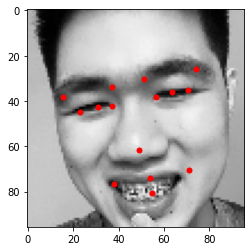

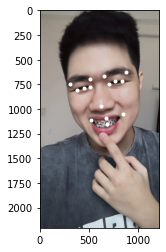

In [5]:
#####  TEST YOUR IMAGE FILE WITH THE MODEL  #####


import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import time

# Load the saved model
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Project AI /Output/model1.h5')  # <-- Saved model path


def detect_points(face_img):
    me  = np.array(face_img)/255
    x_test = np.expand_dims(me, axis=0)
    x_test = np.expand_dims(x_test, axis=3)

    y_test = model.predict(x_test)
    label_points = (np.squeeze(y_test)*48)+48 
    
    return label_points
    
# Load haarcascade
face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/Project AI /haarcascade_frontalface_alt.xml')
dimensions = (96, 96)

# Enter the path to your test image
img = cv2.imread('/content/drive/MyDrive/Project AI /87C30328-36F4-4C41-9A3B-7121C84ACAB6.jpg')

default_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray_img, 1.3, 5)
# faces = face_cascade.detectMultiScale(gray_img, 4, 6)

faces_img = np.copy(gray_img)

plt.rcParams["axes.grid"] = False


all_x_cords = []
all_y_cords = []

for i, (x,y,w,h) in enumerate(faces):
    
    h += 10
    w += 10
    x -= 5
    y -= 5
    
    just_face = cv2.resize(gray_img[y:y+h,x:x+w], dimensions)
    cv2.rectangle(faces_img,(x,y),(x+w,y+h),(255,0,0),1)
    
    scale_val_x = w/96
    scale_val_y = h/96
    
    label_point = detect_points(just_face)
    all_x_cords.append((label_point[::2]*scale_val_x)+x)
    all_y_cords.append((label_point[1::2]*scale_val_y)+y)
   
   
    plt.imshow(just_face, cmap='gray')
    plt.plot(label_point[::2], label_point[1::2], 'ro', markersize=5)
    plt.show()
    
    
plt.imshow(default_img)    
plt.plot(all_x_cords, all_y_cords, 'wo',  markersize=3)
plt.show()


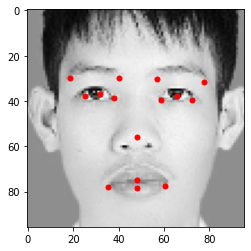

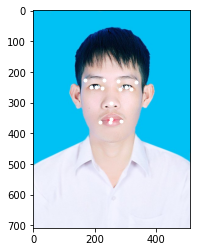

In [3]:
#####  TEST YOUR IMAGE FILE WITH THE MODEL  #####


import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import time

# Load the saved model
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Project AI /Output/model1.h5')  # <-- Saved model path


def detect_points(face_img):
    me  = np.array(face_img)/255
    x_test = np.expand_dims(me, axis=0)
    x_test = np.expand_dims(x_test, axis=3)

    y_test = model.predict(x_test)
    label_points = (np.squeeze(y_test)*48)+48 
    
    return label_points
    
# Load haarcascade
face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/Project AI /haarcascade_frontalface_alt.xml')
dimensions = (96, 96)

# Enter the path to your test image
img = cv2.imread('/content/drive/MyDrive/Project AI /hinh.jpg')

default_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray_img, 1.3, 5)
# faces = face_cascade.detectMultiScale(gray_img, 4, 6)

faces_img = np.copy(gray_img)

plt.rcParams["axes.grid"] = False


all_x_cords = []
all_y_cords = []

for i, (x,y,w,h) in enumerate(faces):
    
    h += 10
    w += 10
    x -= 5
    y -= 5
    
    just_face = cv2.resize(gray_img[y:y+h,x:x+w], dimensions)
    cv2.rectangle(faces_img,(x,y),(x+w,y+h),(255,0,0),1)
    
    scale_val_x = w/96
    scale_val_y = h/96
    
    label_point = detect_points(just_face)
    all_x_cords.append((label_point[::2]*scale_val_x)+x)
    all_y_cords.append((label_point[1::2]*scale_val_y)+y)
   
   
    plt.imshow(just_face, cmap='gray')
    plt.plot(label_point[::2], label_point[1::2], 'ro', markersize=5)
    plt.show()
    
    
plt.imshow(default_img)    
plt.plot(all_x_cords, all_y_cords, 'wo',  markersize=3)
plt.show()


In [6]:
####  TEST YOUR VIDEO FILE WITH THE MODEL  #####


from keras.models import load_model
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import cv2
import time



model = load_model('/content/drive/MyDrive/Project AI /Output/model1.h5')  # <-- Saved model path


# input video file path
input_file = '/content/drive/MyDrive/Project AI /v12044gd0000c6q014rc77ubanrm4li0.MP4'


# output file path
output_filename = '/content/drive/MyDrive/Project AI /testVideo_out.avi'  


def get_points_main(img):

    def detect_points(face_img):
        me  = np.array(face_img)/255
        x_test = np.expand_dims(me, axis=0)
        x_test = np.expand_dims(x_test, axis=3)

        y_test = model.predict(x_test)
        label_points = (np.squeeze(y_test)*48)+48


        return label_points

    # load haarcascade
    face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/Project AI /haarcascade_frontalface_alt.xml')
    dimensions = (96, 96)


    try:
        default_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gray_img = cv2.cvtColor(default_img, cv2.COLOR_RGB2GRAY)
        faces = face_cascade.detectMultiScale(gray_img, 1.3, 5)
#         faces = face_cascade.detectMultiScale(gray_img, 4, 6)

    except:
        return []

    faces_img = np.copy(gray_img)

    plt.rcParams["axes.grid"] = False


    all_x_cords = []
    all_y_cords = []


    for i, (x,y,w,h) in enumerate(faces):

        h += 10
        w += 10
        x -= 5
        y -= 5

        try:
            just_face = cv2.resize(gray_img[y:y+h,x:x+w], dimensions)
        except:
            return []
        cv2.rectangle(faces_img,(x,y),(x+w,y+h),(255,0,0),1)

        scale_val_x = w/96
        scale_val_y = h/96

        label_point = detect_points(just_face)

        all_x_cords.append((label_point[::2]*scale_val_x)+x)
        all_y_cords.append((label_point[1::2]*scale_val_y)+y)



    final_points_list = []
    try:
        for ii in range(len(all_x_cords)):
            for a_x, a_y in zip(all_x_cords[ii], all_y_cords[ii]):
                final_points_list.append([a_x, a_y])
    except:
        return final_points_list

    return final_points_list

# cap = cv2.VideoCapture(0)


cap = cv2.VideoCapture(input_file)
ret, frame = cap.read()
height, width, channel = frame.shape

fourcc = cv2.VideoWriter_fourcc(*'MJPG')
out = cv2.VideoWriter(output_filename, fourcc, 20.0, (width, height))


frame_no = 0
while cap.isOpened():

    a = time.time()
    
    frame_no += 1
    ret, frame = cap.read()
    if frame_no > 75*30:
        break
    if frame_no in range(60*30, 75*30):
        points = get_points_main(frame)

        try:
            overlay = frame.copy()
        except Exception as e:
            print(e)
            break

        for point in points:

            cv2.circle(frame, tuple(point), 3, (255, 255, 255), -1)
            # cv2.line(frame, last_point, tuple(point), (0,0,255), thickness=1)
            # cv2.putText(overlay, str(i), tuple(point), 1, 1, (255, 255, 255))

        if len(points) != 0:
            o_line_points = [[12,13], [13,11], [11,14], [14,12], [12,10], [11,10], [10,3], [12,5], [11,3], [10,5], [10,4], [10,2], [5,1], [1,4], [2,0], [0,3], [5,9], [9,8], [8,4], [2,6], [6,7], [7,3]]
            num_face = len(points)//15

            for i in range(num_face):
                line_points = np.array(o_line_points) + (15*(i))

                the_color = (189, 195, 199)

                for ii in line_points:
                    cv2.line(overlay, tuple(points[ii[0]]), tuple(points[ii[1]]), the_color, thickness=1)


        opacity = 0.3
        cv2.addWeighted(overlay, opacity, frame, 1 - opacity, 0, frame)

        out.write(frame)
        # cv2.imshow('frame',frame)
        b = time.time()
        print(str((b-a)))

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
           

cap.release()
cv2.destroyAllWindows()

'NoneType' object has no attribute 'copy'
